# Pulsars detection in sample of candidates

## Introduction
Pulsars are the class of neutron stars which have a strong electromagnetic field. The astrophysics simulations show that this field accelerates particles (mostly electrons and positrons) up to values close to the speed of light (https://www.youtube.com/watch?v=jwC6_oWwbSE). The part of the positrons cause strong gamma ray emission along the axis of magnetic poles. However, the star rotates around a diffetent fixed axis. Therefore, the beam of emission is pointing toward Earth only once each rotational period. 

<img src="scheme.jpg" width="40%" style="float: left; margin-right: 25px;"/>
<img src="pulsars.gif" width="55%" style="float: left;"/>

We analyse the HTRU2 dataset given by Dr Robert Lyon and available at https://archive.ics.uci.edu/ml/datasets/HTRU2. The dataset consists of the target class and first 4 statistical moments observed for both integrated pulse profile and signal-to-noise ratio of object dispersion measure (DM-SNR). Examples of profile and DM curve of pulsar candidate PSR J1706-6118 are presented in the following figure (http://www.scienceguyrob.com/wp-content/uploads/2016/12/WhyArePulsarsHardToFind_Lyon_2016.pdf).

<img src="IP_DM-SNR.jpg" width="80%" style="float: left; margin-right: 25px;"/>

## Data Overview

The dataset is downloaded and available in the folder `../data/pulsar_stars/`. We import the CSV file by means of Pandas 

In [1]:
import random
import time
from functools import reduce
from math import floor, ceil

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
from benedict import benedict
# from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from scipy import interp
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
data = pd.read_csv('../data/pulsar_stars/pulsar_stars.csv')
data.head(5)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Let us rename the columns to have more compact titles

In [3]:
columns = data.columns
column_names = list(['IP1', 'IP2', 'IP3', 'IP4', 'DM1', 'DM2', 'DM3', 'DM4'])
data = data.rename(columns = {
    columns[0]: column_names[0], columns[1]: column_names[1], columns[2]: column_names[2], columns[3]: column_names[3],
    columns[4]: column_names[4], columns[5]: column_names[5], columns[6]: column_names[6], columns[7]: column_names[7],
    columns[8]: 'target'
})
data.head(4)

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0


The general statistical description of the data is given by

In [4]:
data.describe()

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


It can be seen that standard deviations of features are in range from `1.064040` to `106.514540` and all attributes have non-zero means. We scale the dataset to have unit variances and zero means because it is more convinient to work with.

In [5]:
scaler = StandardScaler()
scaled_data = data.copy()
scaled_data[column_names] = scaler.fit_transform(data[column_names].to_numpy())
scaled_data.describe()

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
count,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,17898.000000
mean,-1.683261e-16,-3.437982e-16,5.716737e-17,1.270386e-17,-5.399140e-17,2.858368e-17,4.382831e-16,3.811158e-17,0.091574
std,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,0.288432
min,-4.103640e+00,-3.182449e+00,-2.212262e+00,-5.775478e-01,-4.207776e-01,-9.736032e-01,-2.539483e+00,-1.003034e+00,0.000000
25%,-3.956882e-01,-6.098955e-01,-4.236418e-01,-3.175961e-01,-3.627611e-01,-6.106403e-01,-5.597136e-01,-6.562405e-01,0.000000
50%,1.558601e-01,5.815398e-02,-2.392997e-01,-2.548046e-01,-3.329443e-01,-4.039644e-01,2.884145e-02,-2.046083e-01,0.000000
75%,6.239604e-01,6.537588e-01,-4.259430e-03,-1.365972e-01,-2.426074e-01,1.079397e-01,5.324947e-01,3.234543e-01,0.000000
max,3.178564e+00,7.632529e+00,7.134956e+00,1.075456e+01,7.151778e+00,4.330538e+00,5.822567e+00,1.019742e+01,1.000000


In order to see if there is dependence between features let us build the correlation matrix 

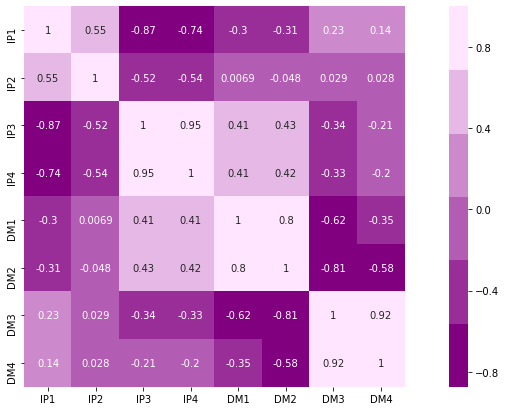

In [6]:
%matplotlib inline

palette = sns.light_palette("purple", reverse = True)

corr = scaled_data.filter(regex = "[^target]").corr()
plt.figure(figsize = (16, 7))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = palette, square = True, annot = True)
plt.show()

There is a strong correlation between `IP3` - `IP4` and `DM3` - `DM4`. However, not every feature is important for our classification issue. This is clearly seen from the following pairwise relationships. The purple points represent pulsars. The distribution densities are fit by histograms and ploted along the main diagnoal for each of the features.

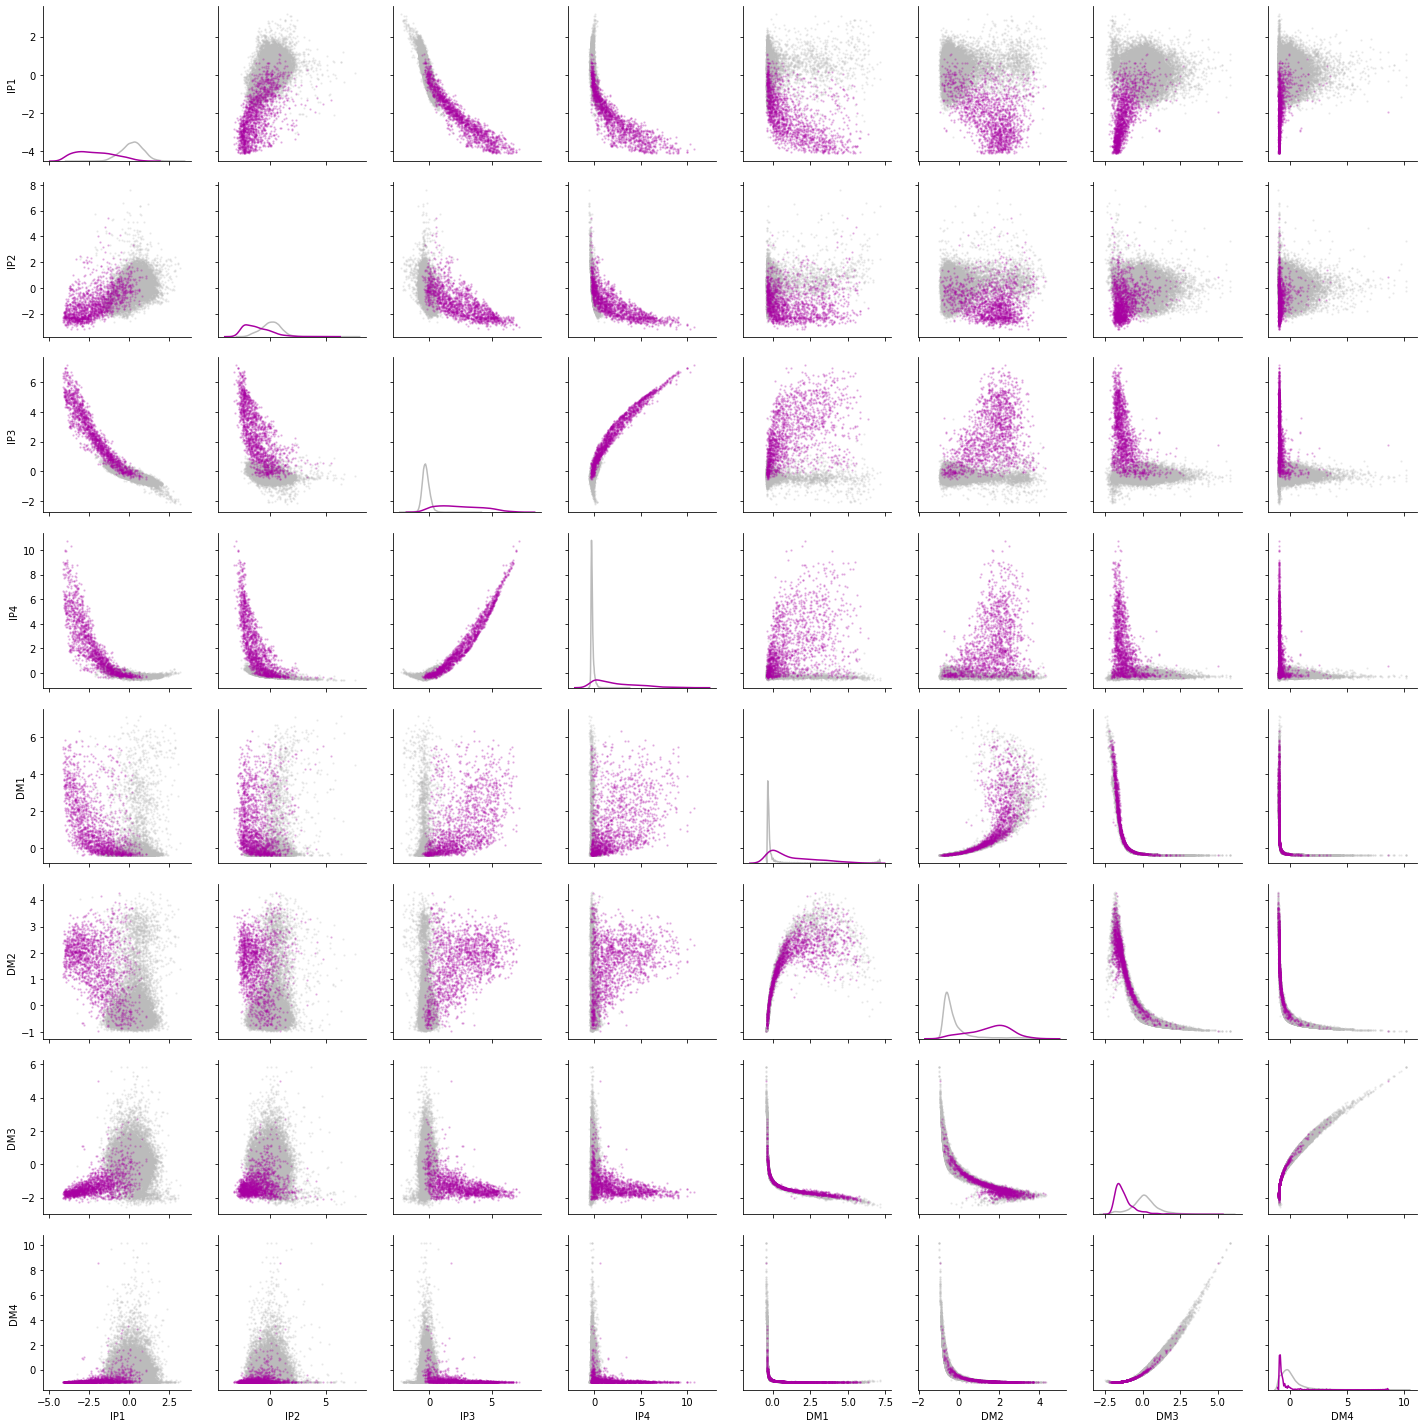

In [7]:
palette2 = sns.color_palette(["#bbbbbb", "#a800a2"])

pg = sns.PairGrid(scaled_data, palette = palette2, hue = "target", hue_order = [0, 1], vars = column_names)

pg.map_diag(sns.kdeplot),
pg.map_offdiag(plt.scatter, s = 2, alpha = 0.2)

It can be seen that some features allows one to split the data set linearly very well.

Another important point is that our data is imbalanced. We should take it into account for some classification algorithms.

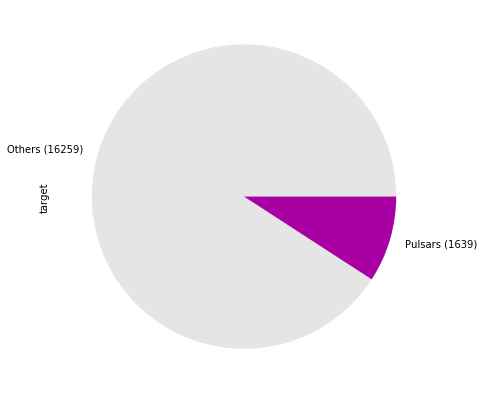

In [8]:
number_of_others, number_of_pulsars = scaled_data.target.value_counts()
scaled_data.target.value_counts().plot(kind = 'pie', labels = ['Others (' + str(number_of_others) + ')',
                                                               'Pulsars (' + str(number_of_pulsars) + ')'],
                                       figsize = (7, 7), colors = ['#e5e5e5', '#a800a2'])

Next, we reduce the dimension of the features using PCA in order to take a look on the data clusters

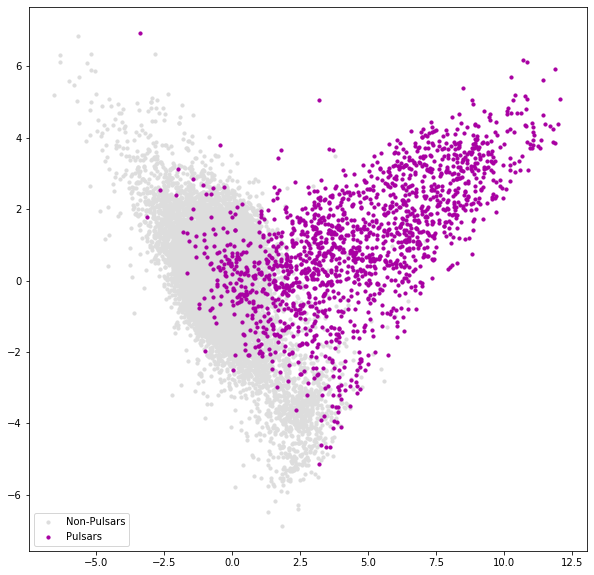

In [9]:
groups = scaled_data.groupby(['target'])
nonPulsarsG = groups.get_group(0)
pulsarsG = groups.get_group(1)

pca = PCA(n_components = 2, random_state = 0)
pca.fit(scaled_data.filter(regex = "[^target]").values)
nonPulsarComponents = pca.transform(nonPulsarsG.filter(regex = "[^target]").values)
pulsarComponents = pca.transform(pulsarsG.filter(regex = "[^target]").values)

others_color = '#dddddd'
pulsars_color = '#a800a2'

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)
ax1.scatter(nonPulsarComponents[:, 0], nonPulsarComponents[:, 1], s = 10, c = others_color, label = 'Non-Pulsars')
ax1.scatter(pulsarComponents[:, 0], pulsarComponents[:, 1], s = 10, c = pulsars_color, label = 'Pulsars')
ax1.axis('tight')
plt.legend(loc = 'lower left');
plt.show()

It is clearly seen that the clusters have some anomalies. Let's remove it by means of Local Outlier Factor alghorithm

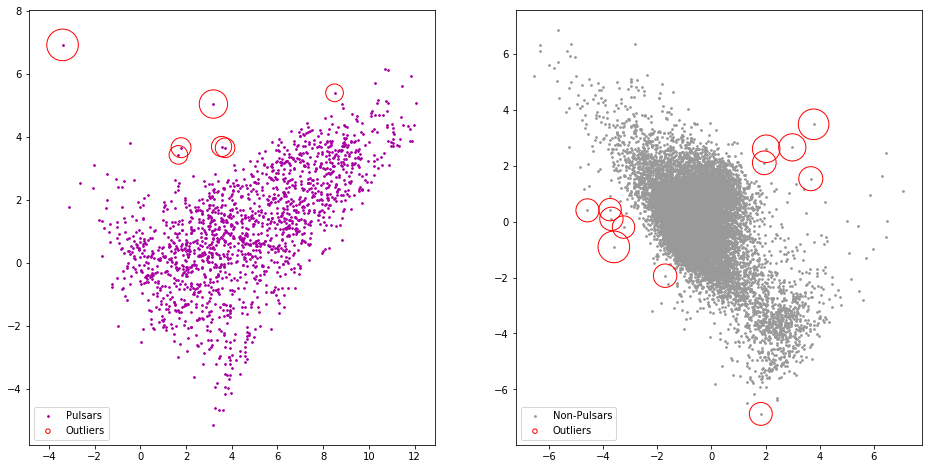

In [10]:
outlier_contamination = 0.1
pulsars_outlier_threshold = 0.3
non_pulsars_outlier_threshold = 0.5

fig = plt.figure(figsize = (16, 8))

clf = LocalOutlierFactor(n_neighbors = 20, contamination = outlier_contamination)
y_outlier_pred = clf.fit_predict(pulsarComponents)
X_scores = clf.negative_outlier_factor_
ax1 = fig.add_subplot(121)
ax1.scatter(pulsarComponents[:, 0], pulsarComponents[:, 1], color = pulsars_color, s = 3., label = 'Pulsars')
pulsars_radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
pulsars_radius[pulsars_radius < pulsars_outlier_threshold] = 0
ax1.scatter(pulsarComponents[:, 0], pulsarComponents[:, 1], s = 1000 * pulsars_radius, edgecolors = 'r',
            facecolors = 'none', label = 'Outliers')
ax1.axis('tight')
legend = ax1.legend(loc = 'lower left')
legend.legendHandles[1]._sizes = [20]

clf = LocalOutlierFactor(n_neighbors = 20, contamination = outlier_contamination)
y_outlier_pred = clf.fit_predict(nonPulsarComponents)
X_scores = clf.negative_outlier_factor_
ax1 = fig.add_subplot(122)
ax1.scatter(nonPulsarComponents[:, 0], nonPulsarComponents[:, 1], color = '#999999', s = 3., label = 'Non-Pulsars')
non_pulsars_radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
non_pulsars_radius[non_pulsars_radius < non_pulsars_outlier_threshold] = 0
ax1.scatter(nonPulsarComponents[:, 0], nonPulsarComponents[:, 1], s = 1000 * non_pulsars_radius, edgecolors = 'r',
            facecolors = 'none', label = 'Outliers')
ax1.axis('tight')
legend = ax1.legend(loc = 'lower left')
legend.legendHandles[1]._sizes = [20]

plt.show()

In [11]:
remove_outliers = True

clear_data = scaled_data.copy()

if remove_outliers:
    outlier_positions = np.where(non_pulsars_radius > 0)[0]
    outlier_indexes = list(map(lambda position: nonPulsarsG.index[position], outlier_positions))
    nonPulsarsOutliers = nonPulsarsG.iloc[outlier_positions, :]
    nonPulsarsClear = nonPulsarsG.drop(outlier_indexes)

    outlier_positions = np.where(pulsars_radius > 0)[0]
    outlier_indexes = list(map(lambda position: pulsarsG.index[position], outlier_positions))
    pulsarsOutliers = pulsarsG.iloc[outlier_positions, :]
    pulsarsClear = pulsarsG.drop(outlier_indexes)

    clear_data = pd.concat([nonPulsarsClear, pulsarsClear]).sample(frac = 1, random_state = 1).reset_index(drop = True)

## Classification Model

We split our dataset to train and test subsets. Note that we add previously detected outliers to the final test subset. The following 3 methods are used in order to train the classification model. The final scores are measured using the test subset.

1. Train classifier using the initial train set with the only pass 
2. Undersample the train set in order to have the same amount of elements in both pulsar and non-pulsar classes. Split data to 5 folds and train using cross-validation
2. Split the pulsars subset to 5 folds. Split non-pulsars to folds with the same size as for pulsars. The method gives 50 folds (5 for pulsars and 45 for non-pulsars) in total. The training is performed using cross-validation

In [12]:
X = clear_data.filter(regex = "[^target]").values
y = clear_data.target.values

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 0)

### Method 1

In [13]:
# Add outliers to the test set
if remove_outliers:
    X_test = np.vstack(
        [nonPulsarsOutliers.filter(regex = "[^target]").values, pulsarsOutliers.filter(regex = "[^target]").values,
         X_test])
    y_test = np.hstack([nonPulsarsOutliers.target.values, pulsarsOutliers.target.values, y_test])

target_names = ['Non-pulsars', 'Pulsars']


def measure_test_performace(classifier):
    y_pred = classifier.predict(X_test)
    report = benedict(classification_report(y_test, y_pred, target_names = target_names, output_dict = True))

    probas = classifier.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probas[:, 1])
    report['auc'] = auc(fpr, tpr)
    report['fpr'] = fpr
    report['tpr'] = tpr

    sample = scaled_data.filter(regex = "[^target]").values

    start = time.time()
    for i in range(1000):
        classifier.predict(sample[[i]])

    prediction_time = time.time() - start

    report['prediction_time'] = prediction_time / 1000

    return report

### Method 2

Let resample our training data to have equal amount of pulsars and the other stars. We use undersampling technique for the further research as it shows better training results.

In [14]:
# sampler = ADASYN()
# X_oversampled, y_oversampled = sampler.fit_sample(X, y)

sampler = RandomUnderSampler(random_state = 1)
X_undersampled, y_undersampled = sampler.fit_sample(X_train, y_train)

print(X.shape)
# print(X_oversampled.shape)
print(X_undersampled.shape)

(17879, 8)
(2352, 8)


Implement classifier evaluation helper function using cross-validation and ROC analysis. We use Stratified K-Fold alghoritm in order to split our data for the training and validation

In [15]:
def average_report(reports):
    result = benedict()
    for path in set(benedict(reports[0]).keypaths()).difference(
            list(['Non-pulsars', 'Pulsars', 'macro avg', 'weighted avg'])):
        average = reduce((lambda acc, report: acc + benedict(report)[path]), reports, 0) / len(reports)
        result[path] = average
    return result


def train_model(classifier, m_X_train, m_y_train, m_X_test, m_y_test, tprs, aucs, reports, mean_fpr):
    classifier.fit(m_X_train, m_y_train)
    y_pred = classifier.predict(m_X_test)
    # Compute reports
    report = classification_report(m_y_test, y_pred, target_names = target_names, output_dict = True)
    # Compute ROC curve and area the curve
    probas = classifier.predict_proba(m_X_test)
    fpr, tpr, thresholds = roc_curve(m_y_test, probas[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    report['auc'] = roc_auc
    reports.append(report)


def measures_stratified_cv(classifier, X_set, y_set, mean_fpr):
    folds = 5
    cv = StratifiedKFold(n_splits = folds, random_state = 0)
    tprs = []
    aucs = []
    reports = []

    i = 0
    for train, test in tqdm(cv.split(X_set, y_set)):
        train_model(classifier, X_set[train], y_set[train], X_set[test], y_set[test], tprs, aucs, reports, mean_fpr)
        i += 1

    result = dict()
    result['tprs'] = tprs
    result['aucs'] = aucs
    result['reports'] = reports
    return result


def evaluate_classifier(classifier, X_set = None, y_set = None, generate_cv_measures = None):
    fig = plt.figure(figsize = (17, 4))

    start = time.time()
    if generate_cv_measures is not None:
        mean_fpr = np.linspace(0, 1, 100)
        measures = generate_cv_measures(classifier, X_set, y_set, mean_fpr)
    else:
        for i in tqdm(range(1)):
            classifier.fit(X_train, y_train)

    train_time = time.time() - start

    overall_report = measure_test_performace(classifier)
    overall_report['train_time'] = train_time

    ax1 = fig.add_subplot(121)
    plt.rcParams["figure.figsize"] = (5, 5)

    if generate_cv_measures is not None:
        tprs = measures['tprs']
        aucs = measures['aucs']
        reports = measures['reports']

        mean_tpr = np.mean(tprs, axis = 0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax1.plot(mean_fpr, mean_tpr, color = '#a800a2',
                 label = r'Mean (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw = 2, alpha = 1)
    else:
        ax1.plot(overall_report['fpr'], overall_report['tpr'], color = '#a800a2',
                 label = r'Mean (AUC = %0.4f)' % (overall_report['auc']), lw = 2, alpha = 1)

    if generate_cv_measures is not None:
        std_tpr = np.std(tprs, axis = 0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                         label = r'$\pm$ $\sigma$')

    ax1.set_aspect(1.0)
    plt.xlim([0, 0.25])
    plt.ylim([0.75, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of ' + classifier.__class__.__name__)
    plt.legend(loc = "lower right")

    ax2 = fig.add_subplot(122)
    font_size = 10
    ax2.axis('off')

    if generate_cv_measures is not None:
        report = average_report(reports)

        def rf(path):
            return "{0:.4f}".format(report[path])

    def gf(path):
        return "{0:.4f}".format(overall_report[path])

    if generate_cv_measures is not None:
        cell_text = [
            [rf('Non-pulsars.precision'), rf('Non-pulsars.recall'), rf('Non-pulsars.f1-score'),
             gf('Non-pulsars.precision'), gf('Non-pulsars.recall'), gf('Non-pulsars.f1-score')],

            [rf('Pulsars.precision'), rf('Pulsars.recall'), rf('Pulsars.f1-score'),
             gf('Pulsars.precision'), gf('Pulsars.recall'), gf('Pulsars.f1-score')],
            [rf('macro avg.precision'), rf('macro avg.recall'), rf('macro avg.f1-score'),
             gf('macro avg.precision'), gf('macro avg.recall'), gf('macro avg.f1-score')],
            [rf('weighted avg.precision'), rf('weighted avg.recall'), rf('weighted avg.f1-score'),
             gf('weighted avg.precision'), gf('weighted avg.recall'), gf('weighted avg.f1-score')]]
    else:
        cell_text = [
            [gf('Non-pulsars.precision'), gf('Non-pulsars.recall'), gf('Non-pulsars.f1-score')],
            [gf('Pulsars.precision'), gf('Pulsars.recall'), gf('Pulsars.f1-score')],
            [gf('macro avg.precision'), gf('macro avg.recall'), gf('macro avg.f1-score')],
            [gf('weighted avg.precision'), gf('weighted avg.recall'), gf('weighted avg.f1-score')]]

    rows_labels = ['Non-Pulsars', 'Pulsars', 'Macro Avg', 'Weighted Avg']

    if generate_cv_measures is not None:
        column_labels = ['CV Avg\nPrecision', 'CV Avg\nRecall', 'CV Avg\nF1-measure', 'Test\nPrecision', 'Test\nRecall',
                         'Test\nF1-measure']
    else:
        column_labels = ['Test\nPrecision', 'Test\nRecall', 'Test\nF1-measure']

    gray = '#dddddd'
    purple = '#eeddee'
    gray_l = '#efefef'
    purple_l = '#ffefff'

    colors = []
    if generate_cv_measures is not None:
        colors = [
            [gray_l, gray_l, gray_l, purple_l, purple_l, purple_l],
            [gray_l, gray_l, gray_l, purple_l, purple_l, purple_l],
            [gray, gray, gray, purple, purple, purple],
            [gray, gray, gray, purple, purple, purple],
        ]
    else:
        colors = [
            [purple_l, purple_l, purple_l],
            [purple_l, purple_l, purple_l],
            [purple, purple, purple],
            [purple, purple, purple],
        ]

    if generate_cv_measures is not None:
        foolter_cell_colors = [[gray_l, gray_l, purple_l, purple_l]]
        cellText = [[r'AUC: %0.4f' % mean_auc, 'Accuracy: ' + rf('accuracy'), r'AUC: %0.4f' % overall_report['auc'],
                     'Accuracy: ' + gf('accuracy')]]
    else:
        foolter_cell_colors = [[purple_l, purple_l]]
        cellText = [[r'AUC: %0.4f' % overall_report['auc'], 'Accuracy: ' + gf('accuracy')]]

    vertical_scaling = 2.5
    footer_2 = plt.table(cellText = [['Train time: %0.4f ms' % (train_time * 1000),
                                      'Prediction time: %0.4f µs' % (overall_report['prediction_time'] * 1000000)]],
                         colLabels = ['', ''],
                         loc = 'bottom',
                         cellColours = [['w', 'w']],
                         cellLoc = 'center',
                         bbox = [0, -0.1, 1, 0.26])

    footer_2.scale(1, vertical_scaling)
    footer_2.auto_set_font_size(False)
    footer_2.set_fontsize(font_size)

    footer = plt.table(cellText = cellText,
                       colLabels = ['', '', '', ''],
                       loc = 'bottom',
                       cellColours = foolter_cell_colors,
                       cellLoc = 'center',
                       bbox = [0, 0.025, 1, 0.26])

    footer.scale(1, vertical_scaling)
    footer.auto_set_font_size(False)
    footer.set_fontsize(font_size)

    table = ax2.table(cellText = cell_text, rowLabels = rows_labels, cellColours = colors,
                      colLabels = column_labels, loc = 'center', cellLoc = 'center')
    table.scale(1, vertical_scaling)
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)

    return overall_report

### Method 3

In [16]:
train_number_of_others = floor((1 - test_size) * number_of_others)
train_number_of_pulsars = floor((1 - test_size) * number_of_pulsars)

non_pulsars_to_pulsars_ratio = floor(train_number_of_others / train_number_of_pulsars)

number_of_pulsars_folds = 5
number_of_non_pulsars_folds = number_of_pulsars_folds * non_pulsars_to_pulsars_ratio

groups = clear_data.groupby(['target'])
nonPulsars = groups.get_group(0)
pulsars = groups.get_group(1)

nonPulsars_X = nonPulsars.copy()
pulsars_X = pulsars.copy()

print('Number of non-pulsar stars is at least', non_pulsars_to_pulsars_ratio, 'times higher.')
new_number_of_others = number_of_non_pulsars_folds * floor(
    non_pulsars_to_pulsars_ratio * train_number_of_pulsars / number_of_non_pulsars_folds)
to_be_removed = train_number_of_others - new_number_of_others
print('Drop', '{0:.1f}'.format(100 * to_be_removed / train_number_of_others),
      '% of non-pulsar stars to have amount divisible by', non_pulsars_to_pulsars_ratio, 'and', number_of_pulsars_folds)

random.seed(5)
indexes_to_remove = list(
    map(lambda i: nonPulsars_X.index[i], np.array(random.sample(range(nonPulsars.shape[0]), to_be_removed))))

nonPulsars_X = nonPulsars_X.drop(indexes_to_remove)

Number of non-pulsar stars is at least 9 times higher.
Drop 9.5 % of non-pulsar stars to have amount divisible by 9 and 5


In [17]:
def split_dataframe_to_chunks(df, n):
    df_len = len(df)
    count = 0
    dfs = []

    while True:
        if count > df_len - 1:
            break

        start = count
        count += n
        dfs.append(df.iloc[start: count])
    return dfs


nonPulsarFolds = split_dataframe_to_chunks(nonPulsars_X, ceil(new_number_of_others / 45))
pulsarFolds = split_dataframe_to_chunks(pulsars_X, ceil(number_of_pulsars / 5))

In [18]:
def measures_full_set_cv(classifier, nonPulsarFolds, pulsarFolds, mean_fpr):
    tprs = []
    aucs = []
    reports = []
    i = 0

    combinations = list(map(lambda k: [k, k % number_of_pulsars_folds], range(0, number_of_non_pulsars_folds)))
    for np_k, p_k in tqdm(combinations):
        np_rest = list(range(0, number_of_non_pulsars_folds))
        np_rest.remove(np_k)

        p_rest = list(range(0, number_of_pulsars_folds))
        p_rest.remove(p_k)

        np_other_folds = pd.concat(list(map(lambda idx: nonPulsarFolds[idx], np_rest)))
        p_other_folds = pd.concat(list(map(lambda idx: pulsarFolds[idx], p_rest)))

        train_folds = pd.concat([np_other_folds, p_other_folds]).sample(frac = 1, random_state = 2).reset_index(
            drop = True)
        test_fold = pd.concat([nonPulsarFolds[np_k], pulsarFolds[p_k]]).sample(frac = 1, random_state = 2).reset_index(
            drop = True)

        train_X = train_folds.filter(regex = "[^target]").values
        train_y = train_folds.target.values

        test_X = test_fold.filter(regex = "[^target]").values
        test_y = test_fold.target.values
        train_model(classifier, train_X, train_y, test_X, test_y, tprs, aucs, reports, mean_fpr)
        i += 1

    result = dict()
    result['tprs'] = tprs
    result['aucs'] = aucs
    result['reports'] = reports
    return result

### Logistic Regression Classifier

100%|██████████| 1/1 [00:00<00:00, 26.92it/s]
5it [00:00, 70.87it/s]
100%|██████████| 45/45 [00:02<00:00, 22.39it/s]


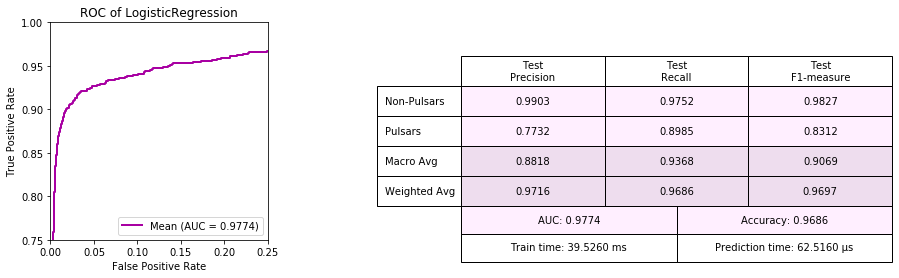

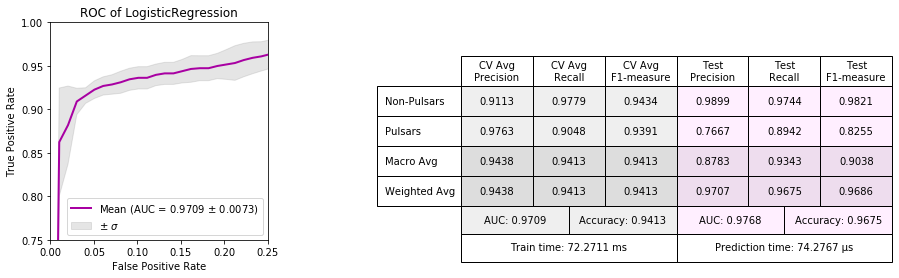

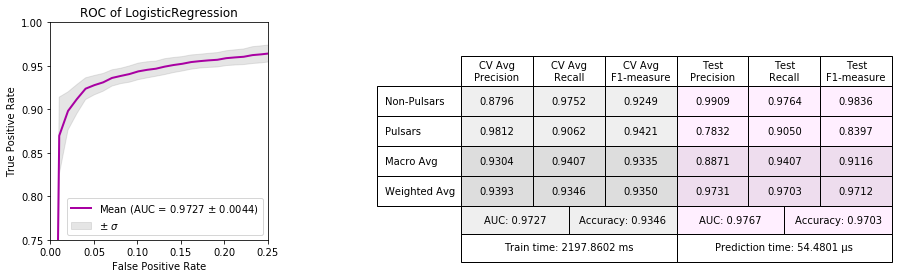

In [19]:
classifier_lr_1 = LogisticRegression(solver = 'lbfgs', random_state = 0, class_weight = 'balanced')
report_lr_1 = evaluate_classifier(classifier_lr_1)

classifier_lr_2 = LogisticRegression(solver = 'lbfgs', random_state = 0, class_weight = 'balanced')
report_lr_2 = evaluate_classifier(classifier_lr_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_lr_3 = LogisticRegression(solver = 'lbfgs', random_state = 0, class_weight = 'balanced')
report_lr_3 = evaluate_classifier(classifier_lr_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### C-Support Vector Classifier

100%|██████████| 1/1 [00:05<00:00,  5.58s/it]
5it [00:00,  9.92it/s]
100%|██████████| 45/45 [03:26<00:00,  4.48s/it]


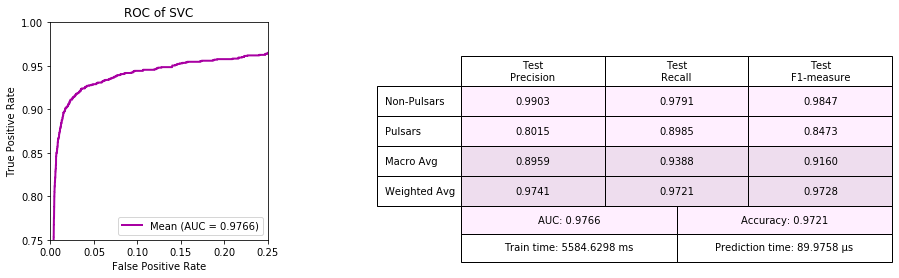

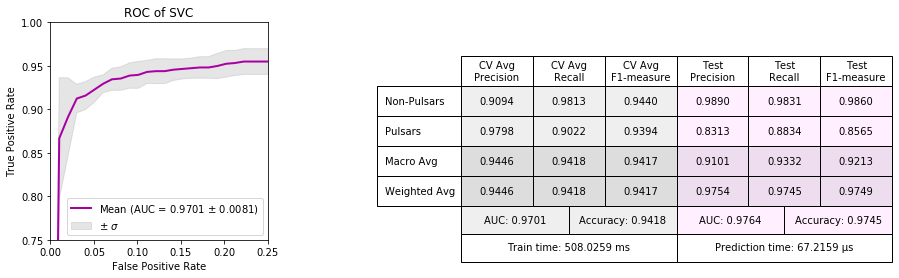

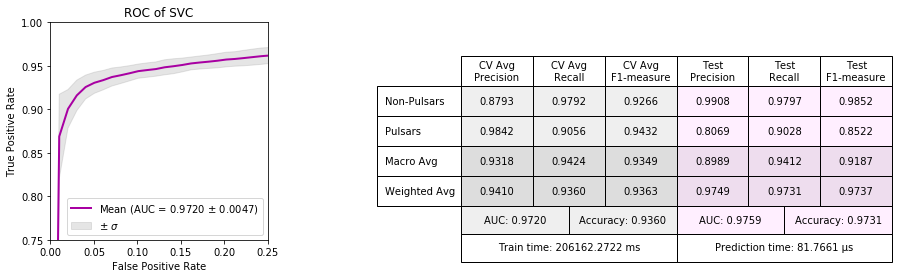

In [20]:
classifier_svm_1 = svm.SVC(kernel = 'linear', probability = True, random_state = 0, class_weight = 'balanced')
report_svm_1 = evaluate_classifier(classifier_svm_1)

classifier_svm_2 = svm.SVC(kernel = 'linear', probability = True, random_state = 0, class_weight = 'balanced')
report_svm_2 = evaluate_classifier(classifier_svm_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_svm_3 = svm.SVC(kernel = 'linear', probability = True, random_state = 0, class_weight = 'balanced')
report_svm_3 = evaluate_classifier(classifier_svm_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### K-Neighbors Classifier

100%|██████████| 1/1 [00:00<00:00, 156.25it/s]
5it [00:00, 45.15it/s]
100%|██████████| 45/45 [00:02<00:00, 20.87it/s]


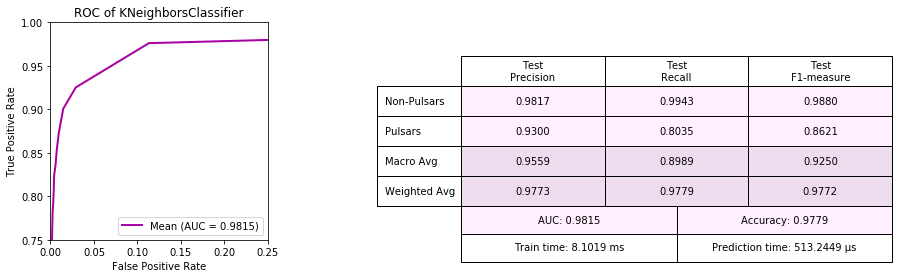

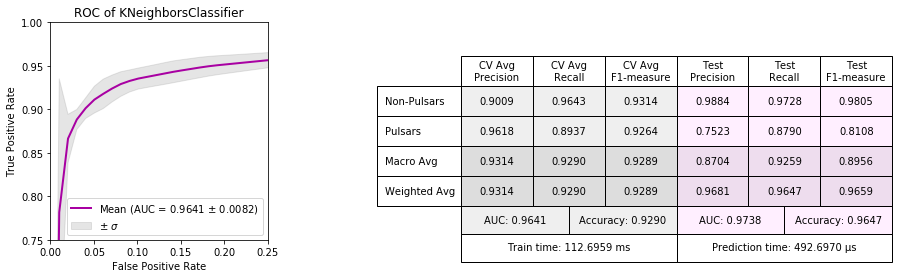

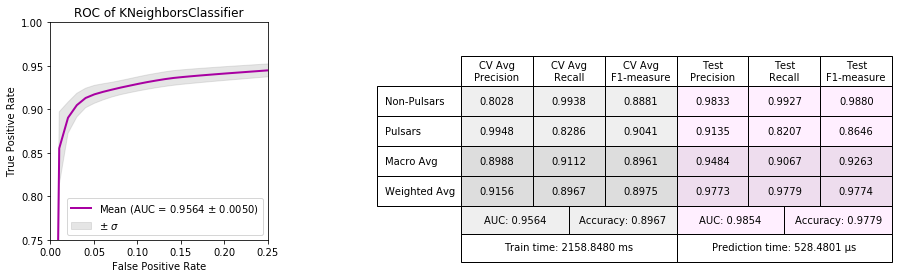

In [21]:
classifier_kn_1 = KNeighborsClassifier(n_neighbors = 13)
report_kn_1 = evaluate_classifier(classifier_kn_1)

classifier_kn_2 = KNeighborsClassifier(n_neighbors = 13)
report_kn_2 = evaluate_classifier(classifier_kn_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_kn_3 = KNeighborsClassifier(n_neighbors = 13)
report_kn_3 = evaluate_classifier(classifier_kn_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### Decision Tree Classifier

100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
5it [00:00, 79.39it/s]
100%|██████████| 45/45 [00:05<00:00,  8.83it/s]


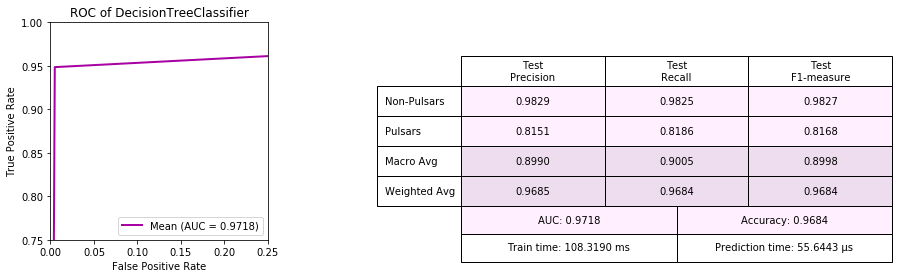

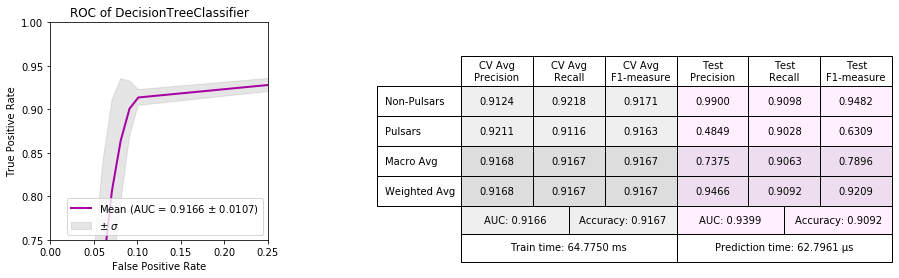

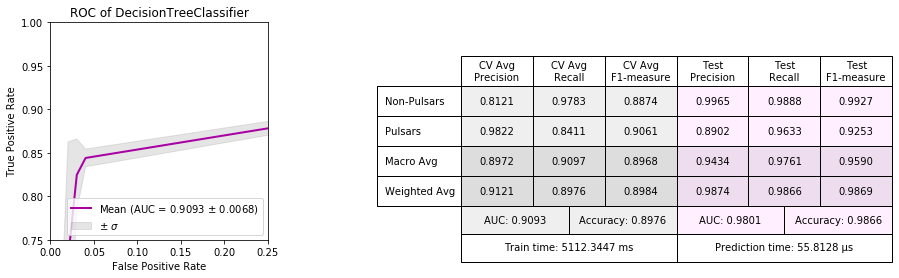

In [22]:
classifier_dt_1 = DecisionTreeClassifier(random_state = 0)
report_dt_1 = evaluate_classifier(classifier_dt_1)

classifier_dt_2 = DecisionTreeClassifier(random_state = 0)
report_dt_2 = evaluate_classifier(classifier_dt_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_dt_3 = DecisionTreeClassifier(random_state = 0)
report_dt_3 = evaluate_classifier(classifier_dt_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### Random Forest Classifier

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]
5it [00:02,  2.11it/s]
100%|██████████| 45/45 [02:36<00:00,  3.47s/it]


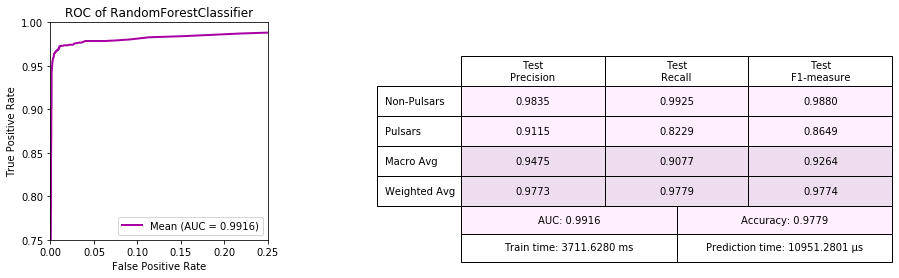

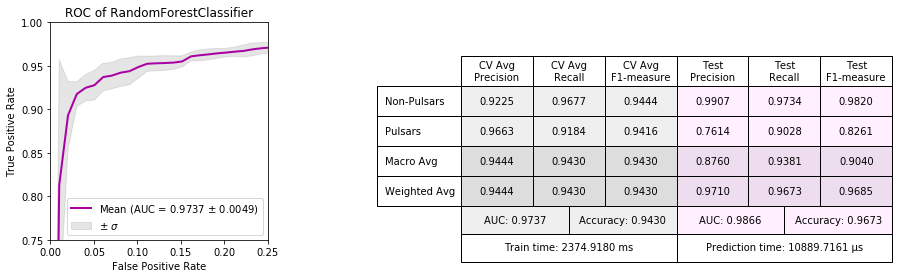

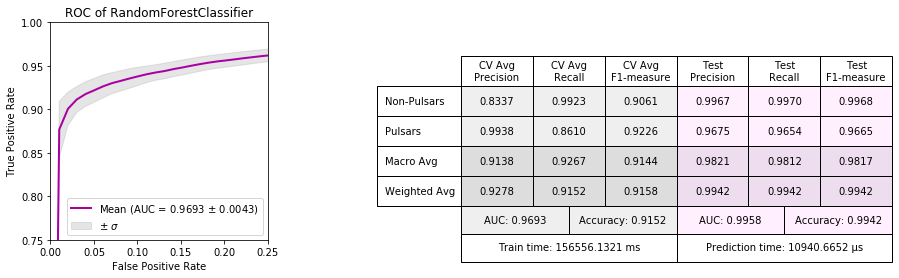

In [23]:
classifier_rf_1 = RandomForestClassifier(n_estimators = 200, random_state = 0)
report_rf_1 = evaluate_classifier(classifier_rf_1)

classifier_rf_2 = RandomForestClassifier(n_estimators = 200, random_state = 0)
report_rf_2 = evaluate_classifier(classifier_rf_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_rf_3 = RandomForestClassifier(n_estimators = 200, random_state = 0)
report_rf_3 = evaluate_classifier(classifier_rf_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### Naive Bayes Classifier

100%|██████████| 1/1 [00:00<00:00, 196.00it/s]
5it [00:00, 205.27it/s]
100%|██████████| 45/45 [00:00<00:00, 69.23it/s]


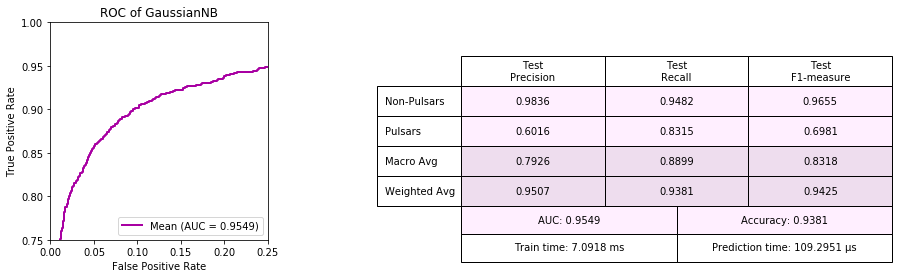

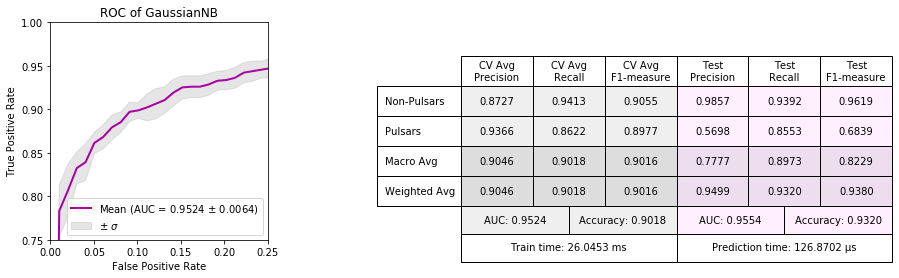

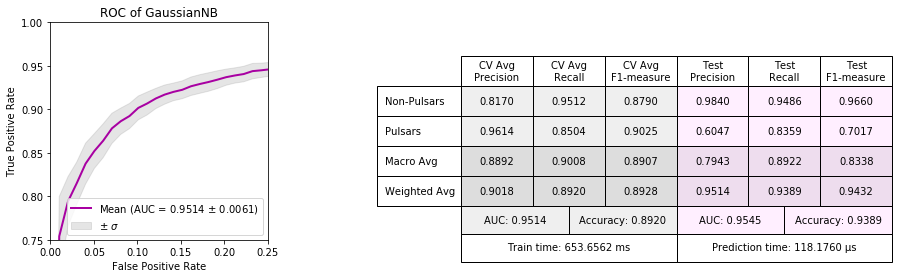

In [24]:
classifier_nb_1 = GaussianNB()
report_nb_1 = evaluate_classifier(classifier_nb_1)

classifier_nb_2 = GaussianNB()
report_nb_2 = evaluate_classifier(classifier_nb_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_nb_3 = GaussianNB()
report_nb_3 = evaluate_classifier(classifier_nb_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### Gradient Boosting Classifier

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
5it [00:00,  8.79it/s]
100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


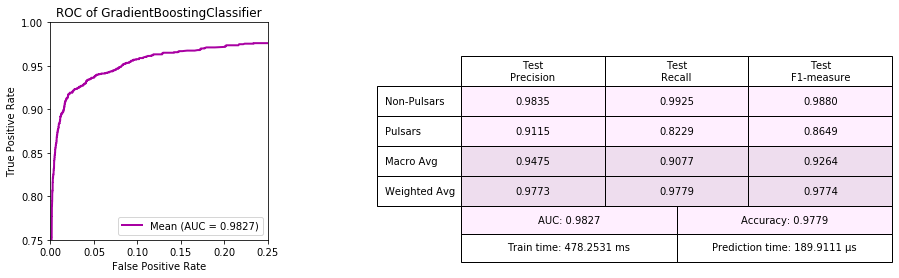

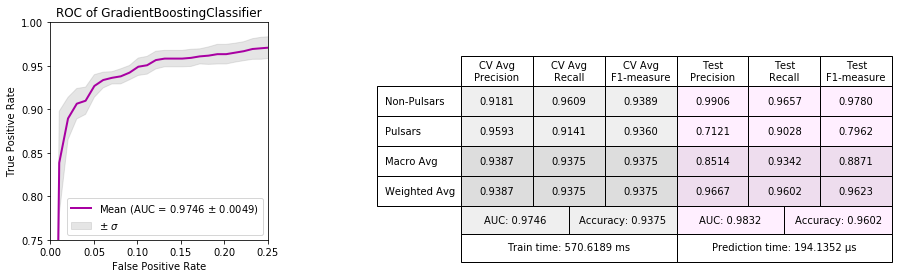

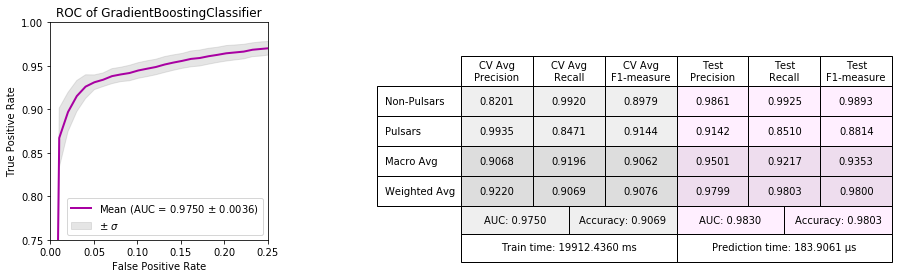

In [25]:
classifier_gb_1 = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.1, max_features = 2,
                                             max_depth = 2, random_state = 0)
report_gb_1 = evaluate_classifier(classifier_gb_1)

classifier_gb_2 = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.1, max_features = 2,
                                             max_depth = 2, random_state = 0)
report_gb_2 = evaluate_classifier(classifier_gb_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_gb_3 = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.1, max_features = 2,
                                             max_depth = 2, random_state = 0)
report_gb_3 = evaluate_classifier(classifier_gb_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

### Neural Network Classifier

100%|██████████| 1/1 [00:08<00:00,  8.28s/it]
0it [00:00, ?it/s]/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
1it [00:02,  2.38s/it]/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
2it [00:04,  2.41s/it]/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
3it [00:07,  2.46s/it]/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/

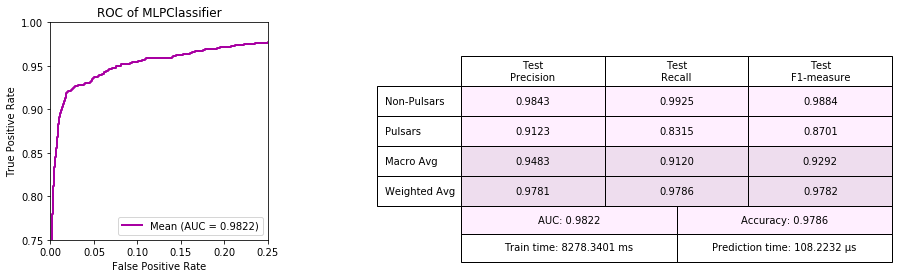

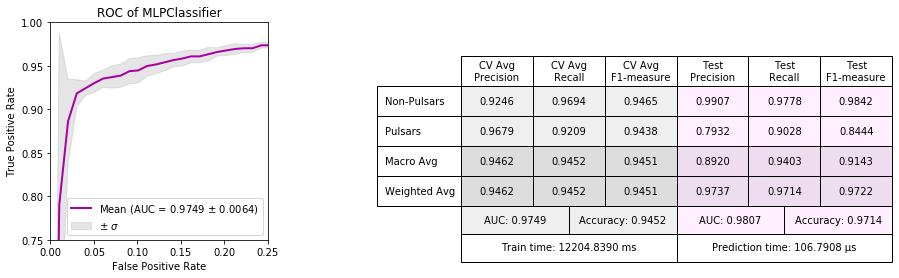

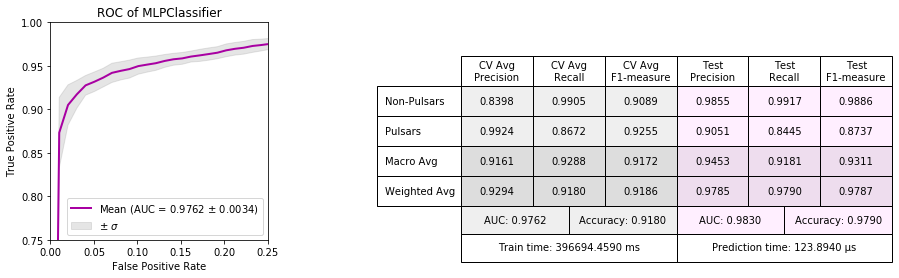

In [26]:
classifier_nn_1 = MLPClassifier(hidden_layer_sizes = (8, 4, 2), max_iter = 500, alpha = 0.00025,
                                solver = 'adam', verbose = 0, random_state = 21, tol = 0.000000001, activation = 'relu')
report_nn_1 = evaluate_classifier(classifier_nn_1)

classifier_nn_2 = MLPClassifier(hidden_layer_sizes = (8, 4, 2), max_iter = 500, alpha = 0.00025,
                                solver = 'adam', verbose = 0, random_state = 21, tol = 0.000000001, activation = 'relu')
report_nn_2 = evaluate_classifier(classifier_nn_2, X_undersampled, y_undersampled, measures_stratified_cv)

classifier_nn_3 = MLPClassifier(hidden_layer_sizes = (8, 4, 2), max_iter = 500, alpha = 0.00025,
                                solver = 'adam', verbose = 0, random_state = 21, tol = 0.000000001, activation = 'relu')
report_nn_3 = evaluate_classifier(classifier_nn_3, nonPulsarFolds, pulsarFolds, measures_full_set_cv)

## Comparative Analysis

Let us summarize the results given by the various alghoritms

In [27]:
reports = np.array([
    [report_lr_1, report_lr_2, report_lr_3],
    [report_svm_1, report_svm_2, report_svm_3],
    [report_kn_1, report_kn_2, report_kn_3],
    [report_dt_1, report_dt_2, report_dt_3],
    [report_rf_1, report_rf_2, report_rf_3],
    [report_nb_1, report_nb_2, report_nb_3],
    [report_gb_1, report_gb_2, report_gb_3],
    [report_nn_1, report_nn_2, report_nn_3]
])

classifier_names = ['Logistic Regression', 'C-Support Vector', 'K-Neighbors', 'Decision Tree', 'Random Forest',
                    'Naive Bayes', 'Gradient Boosting', 'Neural Network'][:reports.shape[0]]

measures_names = ['Accuracy', 'Precision', 'Recall', 'F1-measure', 'AUC', 'Train Time', 'Prediction Time']


def cell(value, name):
    if name == 'auc':
        return "{0:.4f}".format(value)
    elif name == 'train_time':
        return "{0:.4f} ms".format(value * 1000)
    elif name == 'prediction_time':
        return "{0:.4f} µs".format(value * 1000000)
    else:
        return "{0:.4f}".format(value * 100) + ' %'


def row(reports, name):
    return list(map(lambda report: report[name], reports))


accuracies = row(reports[:, 0], 'accuracy') + row(reports[:, 1], 'accuracy') + row(reports[:, 2], 'accuracy')
precisions = row(reports[:, 0], 'Pulsars.precision') + row(reports[:, 1], 'Pulsars.precision') + row(reports[:, 2],
                                                                                                     'Pulsars.precision')
recalls = row(reports[:, 0], 'Pulsars.recall') + row(reports[:, 1], 'Pulsars.recall') + row(reports[:, 2],
                                                                                            'Pulsars.recall')
f1Measures = row(reports[:, 0], 'Pulsars.f1-score') + row(reports[:, 1], 'Pulsars.f1-score') + row(reports[:, 2],
                                                                                                   'Pulsars.f1-score')
AUCs = row(reports[:, 0], 'auc') + row(reports[:, 1], 'auc') + row(reports[:, 2], 'auc')
trainTimes = row(reports[:, 0], 'train_time') + row(reports[:, 1], 'train_time') + row(reports[:, 2], 'train_time')
predictionTimes = row(reports[:, 0], 'prediction_time') + row(reports[:, 1], 'prediction_time') + row(reports[:, 2],
                                                                                                      'prediction_time')

c_results = pd.DataFrame([
    [measures_names[0]] + list(map(lambda v: cell(v, 'accuracy'), accuracies)),
    [measures_names[1]] + list(map(lambda v: cell(v, 'Pulsars.precision'), precisions)),
    [measures_names[2]] + list(map(lambda v: cell(v, 'Pulsars.recall'), recalls)),
    [measures_names[3]] + list(map(lambda v: cell(v, 'Pulsars.f1-score'), f1Measures)),
    [measures_names[4]] + list(map(lambda v: cell(v, 'auc'), AUCs)),
    [measures_names[5]] + list(map(lambda v: cell(v, 'train_time'), trainTimes)),
    [measures_names[6]] + list(map(lambda v: cell(v, 'prediction_time'), predictionTimes))
], columns = [''] + [name + ' ' + str(floor(i / len(classifier_names)) + 1) for i, name in
                     enumerate(classifier_names * 3)])

max_accuracy = cell(max(accuracies), 'accuracy')
max_precision = cell(max(precisions), 'Pulsars.precision')
max_recall = cell(max(recalls), 'Pulsars.recall')
max_f1Measure = cell(max(f1Measures), 'Pulsars.f1-score')
max_auc = cell(max(AUCs), 'auc')
min_train_time = cell(min(trainTimes), 'train_time')
min_prediction_time = cell(min(predictionTimes), 'prediction_time')

max2_accuracy = cell(max(list(filter(lambda v: v != max(accuracies), accuracies))), 'accuracy')
max2_precision = cell(max(list(filter(lambda v: v != max(precisions), precisions))), 'Pulsars.precision')
max2_recall = cell(max(list(filter(lambda v: v != max(recalls), recalls))), 'Pulsars.recall')
max2_f1Measure = cell(max(list(filter(lambda v: v != max(f1Measures), f1Measures))), 'Pulsars.f1-score')
max2_auc = cell(max(list(filter(lambda v: v != max(AUCs), AUCs))), 'auc')
min2_train_time = cell(min(list(filter(lambda v: v != min(trainTimes), trainTimes))), 'train_time')
min2_prediction_time = cell(min(list(filter(lambda v: v != min(predictionTimes), predictionTimes))), 'prediction_time')


def highlighting(x):
    if x == max_accuracy or x == max_precision or x == max_recall or x == max_f1Measure or x == max_auc or x == min_train_time or x == min_prediction_time:
        return 'background-color : ' + pulsars_color + '; color: white'
    if x == max2_accuracy or x == max2_precision or x == max2_recall or x == max2_f1Measure or x == max2_auc or x == min2_train_time or x == min2_prediction_time:
        return 'background-color : #f2c3e9'
    return ''


c_results.reindex(sorted(c_results.columns), axis = 1).T.style.applymap(highlighting)

,0,1,2,3,4,5,6
,Accuracy,Precision,Recall,F1-measure,AUC,Train Time,Prediction Time
C-Support Vector 1,97.2134 %,80.1541 %,89.8488 %,84.7251 %,0.9766,5584.6298 ms,89.9758 µs
C-Support Vector 2,97.4550 %,83.1301 %,88.3369 %,85.6545 %,0.9764,508.0259 ms,67.2159 µs
C-Support Vector 3,97.3063 %,80.6950 %,90.2808 %,85.2192 %,0.9759,206162.2722 ms,81.7661 µs
Decision Tree 1,96.8419 %,81.5054 %,81.8575 %,81.6810 %,0.9718,108.3190 ms,55.6443 µs
Decision Tree 2,90.9158 %,48.4919 %,90.2808 %,63.0943 %,0.9399,64.7750 ms,62.7961 µs
Decision Tree 3,98.6625 %,89.0220 %,96.3283 %,92.5311 %,0.9801,5112.3447 ms,55.8128 µs
Gradient Boosting 1,97.7893 %,91.1483 %,82.2894 %,86.4926 %,0.9827,478.2531 ms,189.9111 µs
Gradient Boosting 2,96.0245 %,71.2095 %,90.2808 %,79.6190 %,0.9832,570.6189 ms,194.1352 µs
Gradient Boosting 3,98.0308 %,91.4153 %,85.0972 %,88.1432 %,0.9830,19912.4360 ms,183.9061 µs


The greatest values of correspondent measures are highlighted. It can be seen that the best ML alghorithm for pulsars classification depends on what measure is going to be used

## Conclusion

Various ML algorithms for the task of pulsars detection are evaluated. The source is re-scaled and re-balanced to have zero mean, unit variance and the same amount of elements in both target classes. We evaluated C-Support Vector, Logistic Regression, K-Neighbors, Decision Tree, Random Forest, Naive Bayes, Gradient Boosting and Neural Network classifiers in order to determine the best one. The general discriminitive ability is given by the area under ROC curve. Third method with adaptive custom cross validation and random forest algorithm shows the best quality of classification. However, the train time is not so good and it takes more time to predict.